In [1]:
import sys, os, re
sys.path.append("/awlab/users/chsu/WorkSpace/tensorflow/segmentation/code")

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import data_io

In [2]:
data_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data'
result_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/results'

exp_name = '2019028023_PC9_A549_with_nuclear_marker'
model_name = 'incucyte_nuc_weighted_bce'

img_dir = os.path.join(data_root, exp_name, 'images')
y_true_dir = os.path.join(data_root, exp_name, 'masks')
y_pred_dir = os.path.join(result_root, model_name, exp_name, 'predictions')
overlay_dir = os.path.join(result_root, model_name, exp_name, 'overlay_ans')

file_type = '*.png'
filter_pattern = None

# Check mean intensity of each image

In [ ]:
img_paths = data_io.get_filenames(img_dir, file_type, filter_pattern)

In [ ]:
int_avg = np.zeros((len(img_paths)))

for i, f in enumerate(img_paths):
    print("Processing {}/{}...".format(i+1, len(img_paths)), end='\r')
    img = cv2.imread(f)
    int_avg[i] = img[...,0].mean()
    

In [ ]:
plt.hist(int_avg)

In [ ]:
data = pd.Series(int_avg)
data.describe()

## => Conclusion: No obvious difference in average intensity

# Find error source

In [3]:
y_true_paths = data_io.get_filenames(y_true_dir, file_type, filter_pattern)
y_pred_paths = data_io.get_filenames(y_pred_dir, file_type, filter_pattern)

In [4]:
def dice_coeff(y_true, y_pred):
    intersect = np.sum((y_true > 0) & (y_pred > 0))
    d = 2. * intersect / (y_true.sum() + y_pred.sum())
    return d

def dice_loss(y_true, y_pred):
    return 1- dice_coeff(y_true, y_pred)

In [5]:
from multiprocessing import Pool
import time

n_workers = 200
n_tasks = len(y_pred_paths)

def get_dl_area(path_pair):
    """path_pair: (y_true_path, y_pred_path)"""
    y_pred = cv2.imread(path_pair[1])[...,0] / 255.
    y_pred = np.float64(y_pred > 0.5)
    
    y_true = cv2.imread(path_pair[0])[...,0] / 255.
    y_true = cv2.resize(y_true, (y_pred.shape[1], y_pred.shape[0]))
    
    DL = dice_loss(y_true, y_pred)
    area = y_pred.sum()
    fname = os.path.basename(path_pair[1])
    
    return DL, area, fname

path_pairs = zip(y_true_paths, y_pred_paths)

print("Calculating dice loss...")
start = time.time()
with Pool(n_workers) as p:
#     DL, area, file_names = zip(*p.map(get_dl_area, path_pairs))
    results = []
    for i, r in enumerate(p.imap(get_dl_area, path_pairs), 1):
        results.append(r)
        print("  Done {}/{}".format(i, n_tasks), end='\r')

DL, area, file_names = zip(*results) 
del results

print("Done (Time elapsed: {}s)".format(int(time.time() - start)))

Calculating dice loss...
Done (Time elapsed: 100s)


In [7]:
# Get well, column, row, frame, time from file name
pattern = re.compile('_(?P<row>[A-Z])(?P<col>\d+)_(?P<frame>\d)_(?P<time>.*)\.png$')
metadata = [pattern.search(f).groupdict() for f in file_names]

In [181]:
def get_cellline(row):
    if row in 'ABCD':
        cellline = 'PC9'
    else:
        cellline = 'A549'
    return cellline

df = pd.DataFrame(metadata)
df['dice_loss'] = DL
df['area'] = area
df['file'] = [os.path.join(overlay_dir, f) for f in file_names]
df['cell_line'] = df['row'].map(get_cellline)
df = df[['cell_line', 'time', 'row', 'col', 'frame', 'dice_loss', 'area', 'file']]
df.head()

,cell_line,time,row,col,frame,dice_loss,area,file
0,PC9,00d00h00m,A,10,1,0.864872,47727.0,/awlab/users/chsu/WorkSpace/tensorflow/segment...
1,PC9,00d02h00m,A,10,1,0.228672,3240.0,/awlab/users/chsu/WorkSpace/tensorflow/segment...
2,PC9,00d04h00m,A,10,1,0.253459,3344.0,/awlab/users/chsu/WorkSpace/tensorflow/segment...
3,PC9,00d06h00m,A,10,1,0.210278,3641.0,/awlab/users/chsu/WorkSpace/tensorflow/segment...
4,PC9,00d08h00m,A,10,1,0.172709,4135.0,/awlab/users/chsu/WorkSpace/tensorflow/segment...


<IPython.core.display.Javascript object>


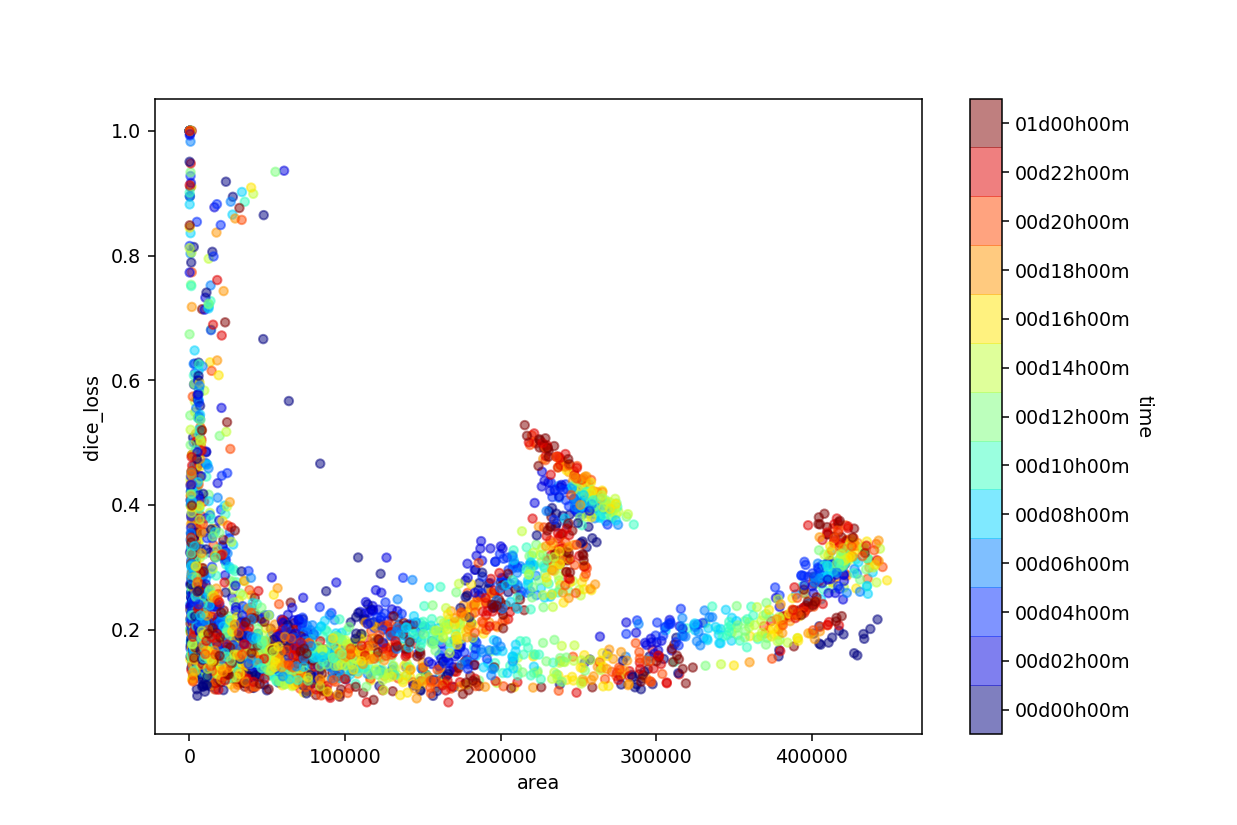

In [213]:
%matplotlib notebook

clr_key = 'time'

clr_grp = df[clr_key].astype('category').cat.categories
clr_idx = df[clr_key].astype('category').cat.codes

ax = df.plot.scatter(x='area', y='dice_loss', style='.', alpha=0.5,
                     c=clr_idx, vmin=-0.5, vmax=len(clr_grp)-0.5,
                     cmap=plt.cm.get_cmap("jet", len(clr_grp)),
                     figsize=(9,6))
fig = ax.get_figure()

# line = ax.lines[0]
line = ax.collections[0]

annot = ax.annotate("", xy=(0,0), xytext=(-10,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    idx = ind["ind"][0]
    
    # for plot
#     x,y = line.get_data()
#     annot.xy = (x[idx], y[idx])
    
    # for scatter
    pos = line.get_offsets()
    annot.xy = pos[idx]
    
    row = df.loc[idx,'row']
    col = df.loc[idx,'col']
    frame = df.loc[idx,'frame']
    time = df.loc[idx,'time']
    
    text = "{}{}_{}_{}\nArea: {:d}\nDice loss: {:.2f}".format(row, col, frame, time, int(x[idx]), y[idx])

    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(1)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

# set colorbar
cb_ax = fig.axes[1]
cb_ax.yaxis.set_ticks(range(len(clr_grp)))
cb_ax.set_yticklabels(clr_grp)
cb_ax.set_ylabel(clr_key, rotation=270, verticalalignment='baseline')

plt.show()


In [ ]:
area_rng = (df['area'] > 200000) & (df['area'] < 300000)
dl_rng = df['dice_loss'] > 0.35
to_check = area_rng & dl_rng

df_check = df[to_check].copy().reset_index(drop=True)
df_check.head()

In [ ]:
def show_overlay(f):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,16))
    plt.imshow(img)
    plt.title(os.path.basename(f))

In [ ]:
%matplotlib notebook
show_overlay(df_check.loc[0,'file'])

In [ ]:
df.hist('dice_loss')

In [ ]:
%matplotlib inline
f = df.loc[0, 'file']
img = cv2.imread(f)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,16))
plt.imshow(img)
plt.title(os.path.basename(f))

In [ ]:
img = np.random.rand(1000,1000)*255.
print(img.shape)
cv2.imwrite('test.png', np.uint8(img))